In [1]:
from __future__ import division
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
import fiona
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
import json
import datetime

In [3]:
df = pd.read_pickle('seattle_dataframe.pkl')

In [4]:
print df.columns

Index([u'v2014', u'v2015', u'v2016', u'hood', u'year', u'sq_ft', u'beds',
       u'baths', u'lot_size', u'pct_inc15', u'pct_inc16', u'COMMERCIAL_ct',
       u'COMMERCIAL_sum', u'SINGLE FAMILY / DUPLEX_ct',
       u'SINGLE FAMILY / DUPLEX_sum', u'MULTIFAMILY_ct', u'MULTIFAMILY_sum',
       u'INSTITUTIONAL_ct', u'INSTITUTIONAL_sum', u'INDUSTRIAL_ct',
       u'INDUSTRIAL_sum'],
      dtype='object')


In [5]:
# Impose limitations to parameters to target single family homes
df = df[(df['sq_ft'] >= 200) & (df['sq_ft'] <= 10000) & (df['baths'] > 0.5)]

# df = df[(df['closing_price'] >= 99) & (df['closing_price'] <= 101)]

In [6]:
print 'max square feet = ', df['sq_ft'].max()
print 'min square feet = ', df['sq_ft'].min()

print 'max baths = ', df['baths'].max()
print 'min baths = ', df['baths'].min()

print df['lot_size'].max()
print df['lot_size'].min()

max square feet =  9830
min square feet =  300
max baths =  7.75
min baths =  0.75
169449
503


In [7]:
print df[(df['lot_size'] <= 700)]

        v2014   v2015   v2016                 hood  year  sq_ft  beds baths  \
1674   418300  380000  409000             Broadway  2012   1140     2  2.00   
2606   462000  520000  560000       Yesler Terrace  2005   1310     2  2.00   
2735   358000  403000  434000             Atlantic  2013   1380     3  2.50   
3152   349000  377000  401000        North Admiral  2009    980     2  2.50   
3955   281000  317000  368000       Fairmount Park  2011   1100     2  2.50   
6625   453000  510000  550000       Yesler Terrace  2005   1240     2  2.00   
6862   200000  235000  282000       North Delridge  2006   1050     3  2.25   
7467   334000  358000  392000  University District  2008    990     2  1.00   
9959   541000  609000  656000     South Lake Union  2003   1440     2  2.50   
11228  349000  377000  401000        North Admiral  2009    980     2  2.50   
11581  541000  609000  656000     South Lake Union  2003   1440     2  2.50   
11682  409000  466000  496000        North Admiral  

In [8]:
df.head()

,v2014,v2015,v2016,hood,year,sq_ft,beds,baths,lot_size,pct_inc15,...,COMMERCIAL_ct,COMMERCIAL_sum,SINGLE FAMILY / DUPLEX_ct,SINGLE FAMILY / DUPLEX_sum,MULTIFAMILY_ct,MULTIFAMILY_sum,INSTITUTIONAL_ct,INSTITUTIONAL_sum,INDUSTRIAL_ct,INDUSTRIAL_sum
0,243000,273000,294000,Atlantic,1921,610,1,1.00,3360,12.345679,...,16.0,1655435.0,46.0,9356542.0,21.0,16484584.0,4.0,181000.0,0.0,0.0
1,1065000,1318000,1443000,Portage Bay,1925,3970,4,3.00,5500,23.755869,...,3.0,55000.0,15.0,2085082.0,0.0,0.0,1.0,2234000.0,0.0,0.0
2,171000,198000,227000,Highland Park,1942,750,2,1.00,4876,15.789474,...,4.0,110000.0,21.0,2805307.0,0.0,0.0,0.0,0.0,1.0,35000.0
3,301000,303000,337000,Holly Park,2005,1770,3,3.50,2253,0.664452,...,1.0,154540.0,2.0,25000.0,0.0,0.0,1.0,226380.0,0.0,0.0
4,384000,420000,449000,Matthews Beach,1955,1410,3,1.00,5355,9.375000,...,0.0,0.0,48.0,5720796.0,2.0,66000.0,0.0,0.0,0.0,0.0


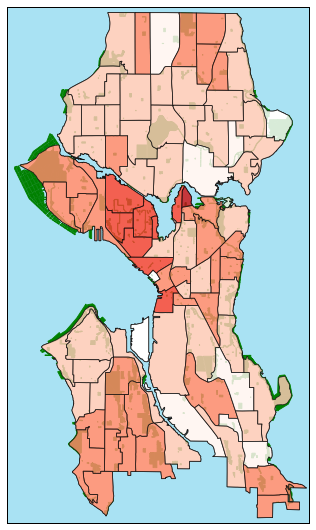

In [26]:
def parse_shapes(shapefilepath):
    '''
    INPUT: path to directory containing shape file
    OUTPUT: coordinates of the shapes to plot
    Takes a shape file (.shp) and return coordinates for plotting'''

    shp = fiona.open(shapefilepath+'.shp')
    coords = shp.bounds
    shp.close
    return coords


def plot_initializer(coordinates):
    '''
    INPUT: coordinates for a set of shapes
    OUTPUT: plot handle and basemap object
    Takes coordinates for a set of shapes and initializes a basemap figure'''

    w, h = coordinates[2] - coordinates[0], coordinates[3] - coordinates[1]
    extra = 0.01

    figwidth = 8
    fig = plt.figure(figsize=(figwidth, figwidth*h/w))
    ax = fig.add_subplot(111, axisbg='w', frame_on=False)
    m = Basemap(
        projection='tmerc', ellps='WGS84',
        lon_0=np.mean([coordinates[0], coordinates[2]]),
        lat_0=np.mean([coordinates[1], coordinates[3]]),
        llcrnrlon=coordinates[0] - extra * w,
        llcrnrlat=coordinates[1] - (extra * h),
        urcrnrlon=coordinates[2] + extra * w,
        urcrnrlat=coordinates[3] + (extra * h),
        resolution='i',  suppress_ticks=True)
    return m, ax


def make_shape_dataframe(m, shapefilename, df_key=None):
    '''
    INPUT: basemape object and shape file name
    OUTPUT: dataframe of shapes
    Takes a basemap object shape file and returns a dataframe of polygons that will plot on the basemap'''

    _out = m.readshapefile(shapefilename, name='seattle', drawbounds=False, color='none', zorder=2)
    # set up a map dataframe for shape outlines
    if df_key == 'S_HOOD':
        df = pd.DataFrame({
            'poly': [Polygon(points) for points in m.seattle],
            'name': [item[df_key] for item in m.seattle_info],
        })
    else:
        df = pd.DataFrame({
            'poly': [Polygon(points) for points in m.seattle],})
    return df


def plot_shapes(df_map, ax):
    '''
    INPUT: dataframe of polygons and plot handle
    OUTPUT: None
    Takes a dataframe of polygons and plot handle and adds patches to plot'''
    pc = PatchCollection(df_map['patches'], match_original=True)
    ax.add_collection(pc)


# ''' Plot Seattle Shorelines '''
shore_shapefilename = 'data/Shorelines/WGS84/Shorelines'
coords = parse_shapes(shore_shapefilename)  # Read in neighborhood shape file
m, ax = plot_initializer(coords)  # Initialize the plot, this only needs to be done once
df_shore = make_shape_dataframe(m, shore_shapefilename)  # get dataframe for plotting
df_shore['patches'] = df_shore['poly'].map(lambda x: PolygonPatch(x, ec='b',  # draw the parks as green patches
                                           lw=.8, facecolor='b', alpha=1, zorder=4))
# plot_shapes(df_shore, ax)  # add to the plot

''' Plot Seattle Neighborhoods '''
hood_shapefilename = 'data/Neighborhoods/WGS84/Neighborhoods'
df_map = make_shape_dataframe(m, hood_shapefilename, 'S_HOOD')  # get neighborhood dataframe for plotting
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#111111',  # draw neighborhoods with grey outlines
                                       lw=.8, facecolor='w', alpha=1., zorder=4))
plot_shapes(df_map, ax)

grouped = df.groupby(['hood']).mean().reset_index()
values = grouped['pct_inc15']
cm = plt.get_cmap('Reds')
num_colors = 5
scheme = [cm(i / num_colors) for i in range(num_colors)]
bins = np.linspace(values.min(), values.max(), num_colors)
grouped['bin'] = np.digitize(values, bins) - 1

for shape, hood in zip(df_map['patches'], df_map['name']):
    b = grouped.loc[grouped['hood'] == hood]['bin'].values
    if len(b) > 0:
        color = scheme[b[0]]
        
    else:
        color = [1, 1, 1]
    shape.set_facecolor(color)
    shape.set_alpha(0.85)
    ax.add_patch(shape)

''' Plot Seattle Parks '''
park_shapefilename = 'data/City of Seattle Parks/WGS84/City_of_Seattle_Parks'
df_map_park = make_shape_dataframe(m, park_shapefilename)  # get dataframe for plotting
df_map_park['patches'] = df_map_park['poly'].map(lambda x: PolygonPatch(x, ec='g',  # draw the parks as green patches
                                                 lw=.8, facecolor='g', alpha=1, zorder=4))
plot_shapes(df_map_park, ax)  # add parks to the plot

''' Draw the map '''
m.drawmapboundary(fill_color='#A9E2F3')
plt.savefig('seattle_map.png')
plt.show()


In [10]:
grouped.columns

Index([u'hood', u'v2014', u'v2015', u'v2016', u'year', u'sq_ft', u'beds',
       u'lot_size', u'pct_inc15', u'pct_inc16', u'COMMERCIAL_ct',
       u'COMMERCIAL_sum', u'SINGLE FAMILY / DUPLEX_ct',
       u'SINGLE FAMILY / DUPLEX_sum', u'MULTIFAMILY_ct', u'MULTIFAMILY_sum',
       u'INSTITUTIONAL_ct', u'INSTITUTIONAL_sum', u'INDUSTRIAL_ct',
       u'INDUSTRIAL_sum', u'bin'],
      dtype='object')

In [11]:
from sklearn.linear_model import LinearRegression
# X_chosen_cols = X_new[chosen_columns]

# plot_model(X_chosen_cols, y_new)
# summary_model(X_chosen_cols, y_new)
df.columns

Index([u'v2014', u'v2015', u'v2016', u'hood', u'year', u'sq_ft', u'beds',
       u'baths', u'lot_size', u'pct_inc15', u'pct_inc16', u'COMMERCIAL_ct',
       u'COMMERCIAL_sum', u'SINGLE FAMILY / DUPLEX_ct',
       u'SINGLE FAMILY / DUPLEX_sum', u'MULTIFAMILY_ct', u'MULTIFAMILY_sum',
       u'INSTITUTIONAL_ct', u'INSTITUTIONAL_sum', u'INDUSTRIAL_ct',
       u'INDUSTRIAL_sum'],
      dtype='object')